In [184]:
import sys
import numpy as np
from scipy import ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq, kmeans, whiten
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.signal import argrelextrema
%matplotlib inline


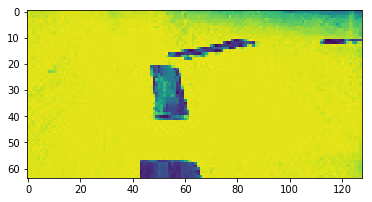

In [214]:
if 1:
    im = ndimage.imread('0000.jpg', mode='L')
    im = ndimage.zoom(im[im.shape[0]//3:,:], 1.0)
    #im = ndimage.zoom(im, 0.5)
    #im = ndimage.filters.maximum_filter(im, size=(5,5))
    im = ndimage.median_filter(im, 1)
else:
    im = ndimage.imread('real.jpg', mode='L')
    im = ndimage.zoom(im[im.shape[0]//2 + im.shape[0]//10:im.shape[0] - im.shape[0]//10,:], 0.9)
   
plt.imshow(im)


[1 1 1 ..., 1 1 1]


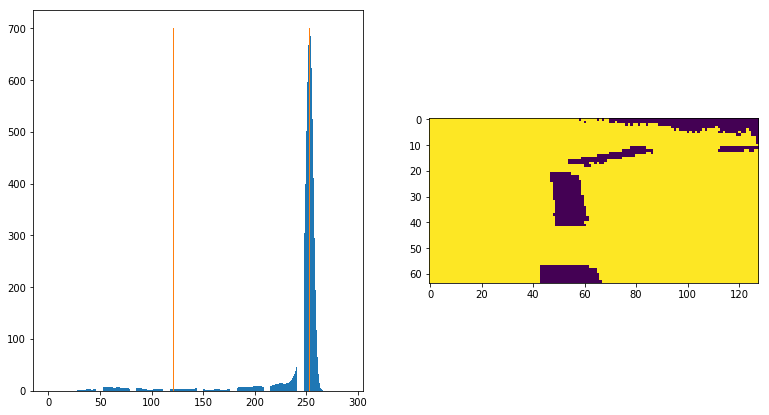

In [215]:
def im_histogram(im):
   
    hist, edges = np.histogram(im, bins=np.arange(256))
    return hist


    
def calculate_colors(im, lpf_size=10, lpf_passes=4, plot=None):
    hist = im_histogram(im)
    
    # low pass filter
    w = np.hanning(lpf_size)
    for x in range(lpf_passes):
        hist = np.convolve(w/w.sum(), hist)
   
    h = np.column_stack((np.linspace(0, hist.max(), hist.size), hist))

    maxs = argrelextrema(h[:, 1], np.greater, order=10)[0]
    maxs = kmeans(maxs.astype(np.float), 2)[0].astype(np.int)
    if plot:
        plot.figure(figsize=(13,7))
        plot.subplot(121)
        plot.bar(range(0, hist.size), h[:,1])
        plot.bar(maxs, np.ones(maxs.size)*hist.max())
        plot.subplot(122)
        
   

    # find the nearest top color for each color
    def mm(x):
        idx = 0
        m = 25500
        for i, v in enumerate(maxs):
            if abs(v - x) < m: 
                idx = i
                m = abs(v - x)
        return idx

    lookup = np.vectorize(mm)(range(hist.size))
    paletted = np.vectorize(lambda x: lookup[x])(im)
    
    paletted = vq(im.flatten(),maxs)[0]
    print(paletted)
    paletted.shape = im.shape
    if plot:
        plot.imshow(paletted)
        
        
    
    # calcualte pixels sums
    sums = np.zeros(maxs.size)
    for i, x in enumerate(lookup):
        sums[x] += hist[i]
    
    # sort peaks by the number of colors (likely higher frequencies can be discarded)
    a = np.column_stack((range(0, maxs.size), maxs , hist[maxs], sums, sums/paletted.size))
    maximums = a[a[:, 3].argsort()]
    return maximums, paletted


maximums, paletted = calculate_colors(im, plot=plt)


/opt/conda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


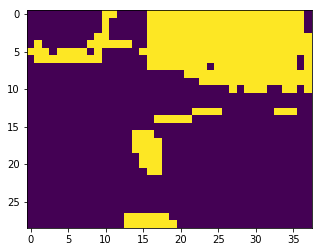

In [194]:
plt.imshow(ndimage.zoom(paletted, 0.3))

In [188]:
maximums

array([[  1.00000000e+00,   1.21000000e+02,   3.58604842e+00,
          6.09178625e+02,   7.43626251e-02],
       [  0.00000000e+00,   2.53000000e+02,   7.00056475e+02,
          7.58282137e+03,   9.25637375e-01]])

In [195]:
def extract_lines(image, color_index, plot=None):
    x, y = np.where(image == color_index)
    X = np.column_stack((x, y)) 
    if X.size == 0 or X.shape[0] > image.size * 0.2:
        return []
    try:
        db = DBSCAN(eps=2, min_samples=3).fit(X)
    except ValueError:
        print(X)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
   
    coords = []
    for c in set(labels):
        # label -1 means "noise"
        if c != -1:
            class_member_mask = (labels == c)
            coords.append(X[class_member_mask])
    pol = []
    errors = []
    for x in coords:
      try:
          pfd = np.polyfit(x[:,0], x[:, 1], 1)
          bbox = [x[:,0].min(), x[:,0].max(),x[:,1].min(), x[:,1].max()]

          # compute varianze
          xx = np.poly1d(pfd)
          err = (xx(x[:,0]) - x[:,1]).var()
          weight = float(x.shape[0])/im.size
          if weight > 0.000005: 
              pol.append((x, pfd, err, weight, bbox))
     
      except ValueError:
          print(x)


    if plot:
        
        for c, po, err, weight, bbox in pol:
           xp = np.linspace(bbox[0], bbox[1] , 100)
           p = np.poly1d(po)
           _ = plot.plot(c[:,1], c[:, 0], '.', p(xp), xp, '-')

   
    return pol

/opt/conda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


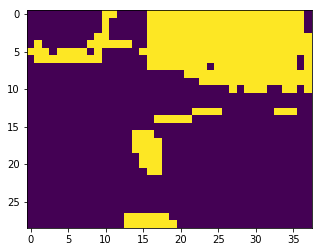

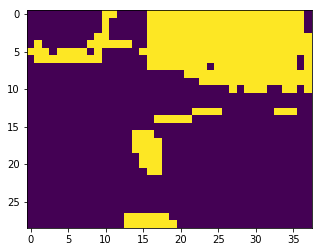

In [196]:
#plt.figure(figsize=(7,4*maximums.size))

#fig, ax = plt.subplots()
ax = plt
plt.figure()
final_image = ndimage.zoom(paletted, 0.3)
#paletted = ndimage.zoom(paletted, 0.3)
for i, x in enumerate(maximums[:,0]):
    ax.imshow(final_image)
    #ax.imshow(np.random.random((10,10)))
    ax.autoscale(False)
    pols = extract_lines(final_image, x, plot=ax)
    for x in pols:
        print (x[2:])
    plt.show()
plt.show()

